In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv(
    'Data/smile-annotations-final.csv',
    names=['id', 'text', 'category'])
df.set_index('id', inplace=True)

In [3]:
df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [4]:
df.category.value_counts()

category
nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: count, dtype: int64

In [5]:
df = df[~df.category.str.contains('\|')] #Remove rows in 'category' column that contain the '|' symbol

In [6]:
df = df[df.category != 'nocode'] #Remove rows in 'category' column that contain the 'nocode'

In [7]:
df.category.value_counts()

category
happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: count, dtype: int64

In [8]:
possible_labels = df.category.unique() #Get unique category labels from the DataFrame column 'category'

In [9]:
label_dict = {} #Create a dictionary to map each possible label to a unique index
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [10]:
label_dict

{'happy': 0,
 'not-relevant': 1,
 'angry': 2,
 'disgust': 3,
 'sad': 4,
 'surprise': 5}

In [11]:
df['label'] = df.category.replace(label_dict)
df.head(10)

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0
614499696015503361,Lucky @FitzMuseum_UK! Good luck @MirandaStearn...,happy,0
613601881441570816,Yr 9 art students are off to the @britishmuseu...,happy,0
613696526297210880,@RAMMuseum Please vote for us as @sainsbury #s...,not-relevant,1
610746718641102848,#AskTheGallery Have you got plans to privatise...,not-relevant,1


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
#Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.15,
    random_state=17,
    stratify=df.label.values
)

In [14]:
df['data_type'] = ['not_set']*df.shape[0] #Set a new column 'data_type' for later data split

In [15]:
df.head()

,text,category,label,data_type
id,,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0,not_set
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0,not_set
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0,not_set
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0,not_set
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0,not_set


In [16]:
#Set the 'data_type' column of the dataframe for training and validation data
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [17]:
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      3     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     5     train        30
                   val           5

In [18]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [19]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [20]:
#Tokenize and encode the text data for both training and validation sets
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

#Get input ids, attention masks, and labels for the training set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

#Get input ids, attention masks, and labels for the validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/z123010/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [22]:
len(dataset_train)

1258

In [23]:
len(dataset_val)

223

In [24]:
from transformers import BertForSequenceClassification

In [25]:
#Define a BERT model for sequence classification task
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)

"""
Here, I use the BERTForSequenceClassification model, which is a BERT model for sequence classification
task such as sentiment analysis. The pre-trained BERT model is loaded from 'bert-base-uncased', and we set the number of labels to be the length of unique labels in the dataset.

I also set output_attentions and output_hidden_states to False, which means I only get the output
from the last layer of BERT.
"""

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

"\nHere, I use the BERTForSequenceClassification model, which is a BERT model for sequence classification\ntask such as sentiment analysis. The pre-trained BERT model is loaded from 'bert-base-uncased', and we set the number of labels to be the length of unique labels in the dataset.\n\nI also set output_attentions and output_hidden_states to False, which means I only get the output\nfrom the last layer of BERT.\n"

In [26]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [27]:
# Set the batch size and create data loaders for training and validation sets

batch_size = 1 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [28]:
from transformers import AdamW, get_linear_schedule_with_warmup

2023-06-06 13:10:30.085990: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-06 13:10:30.107077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 13:10:30.494667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [29]:
optimizer = AdamW(
    model.parameters(),  # Passes the model parameters to the optimizer
    lr=1e-5,             # Sets the learning rate for the optimizer to 1e-5
    eps=1e-8             # Sets the epsilon value for numerical stability to 1e-8
)

/home/z123010/.local/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
epochs= 10 #This sets the number of epochs or the number of times the model will iterate over the entire dataset during training to 10.

#This creates a linear learning rate scheduler that increases the learning rate linearly over the course of training and uses the specified number of warm-up steps and total training steps.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, #This sets the number of warm-up steps during training to 0. Warm-up steps gradually increase the learning rate from an initial low value to the target learning rate.
    num_training_steps=len(dataloader_train)*epochs #This sets the number of total training steps to the number of batches per epoch times the number of epochs.
)

In [31]:
import numpy as np

In [32]:
from sklearn.metrics import f1_score #F1 score is a measure of a model's accuracy, combining both precision and recall, used to evaluate binary classification models.

In [33]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

In [34]:
def accuracy_per_class(preds, labels):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Iterate over the unique labels in the actual labels.
    for label in np.unique(labels_flat):
        # Get the predicted labels for this class.
        y_preds = preds_flat[labels_flat==label]
        
        # Get the actual labels for this class.
        y_true = labels_flat[labels_flat==label]
        
        # Print the class name, accuracy numerator and denominator.
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [35]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [37]:
#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals




In [38]:
import time
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning
import matplotlib.pyplot as plt
from tabulate import tabulate

total_training_time = 0

training_loss_list = []
validation_loss_list = []
accuracy_list = []
precision_list = []
f1_score_list = []

previous_results = None  # Store previous epoch results

for epoch in tqdm(range(1, epochs + 1)):
    start_time = time.time()

    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }
        output = model(**inputs)
        loss = output[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    torch.save(model.state_dict(), f'Models/finetuned_gpt_ft_epoch{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_val)

    # Convert predictions to discrete labels
    predictions = np.argmax(predictions, axis=1)

    val_f1 = f1_score(true_vals, predictions, average='weighted')
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

    val_accuracy = accuracy_score(true_vals, predictions)
    val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)

    # Compute and store metrics
    training_loss_list.append(loss_train_avg)
    validation_loss_list.append(val_loss)
    f1_score_list.append(val_f1)
    accuracy_list.append(val_accuracy)
    precision_list.append(val_precision)

    # Check if there are previous results to compare with
    if previous_results is not None:
        if loss_train_avg > previous_results['loss_train_avg']:
            percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
            tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
        if loss_train_avg < previous_results['loss_train_avg']:
            percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
            tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
        if val_loss > previous_results['val_loss']:
            percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
            tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
        if val_loss < previous_results['val_loss']:
            percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
            tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
        if val_f1 < previous_results['val_f1']:
            percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
            tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
        if val_f1 > previous_results['val_f1']:
            percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
            tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')

    # Store current results as previous results for the next epoch
    previous_results = {
        'loss_train_avg': loss_train_avg,
        'val_loss': val_loss,
        'val_f1': val_f1
    }

total_time_minutes = total_training_time / 60
tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')

final_accuracy = accuracy_list[-1]
final_precision = precision_list[-1]
tqdm.write(f'Final Accuracy: {final_accuracy}')
tqdm.write(f'Final Precision: {final_precision}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1258 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9903249319029057
Validation loss: 0.740173748803467
F1 Score (weighted): 0.7907248376268841


Epoch 2:   0%|          | 0/1258 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5530843209114003
Validation loss: 0.8539395827092408
F1 Score (weighted): 0.8079317446210739
44.15% Training loss decreased compared to the previous epoch
15.37% Validation loss increased compared to the previous epoch
2.18% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/1258 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.39525855790404907
Validation loss: 1.0032353615713245
F1 Score (weighted): 0.8390777530041502
28.54% Training loss decreased compared to the previous epoch
17.48% Validation loss increased compared to the previous epoch
3.86% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/1258 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2630351473203135
Validation loss: 0.929145656477343
F1 Score (weighted): 0.8470039674891462
33.45% Training loss decreased compared to the previous epoch
7.39% Validation loss decreased compared to the previous epoch
0.94% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/1258 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.15620169965942385
Validation loss: 0.9290453352089657
F1 Score (weighted): 0.8552659437605683
40.62% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch
0.98% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/1258 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.07457581777445496
Validation loss: 0.9052205499280835
F1 Score (weighted): 0.8586208168122407
52.26% Training loss decreased compared to the previous epoch
2.56% Validation loss decreased compared to the previous epoch
0.39% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/1258 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.032941711816703544
Validation loss: 1.0975182230981466
F1 Score (weighted): 0.8603884448891622
55.83% Training loss decreased compared to the previous epoch
21.24% Validation loss increased compared to the previous epoch
0.21% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/1258 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.016761633110461305
Validation loss: 1.1167227467045744
F1 Score (weighted): 0.8606888369706002
49.12% Training loss decreased compared to the previous epoch
1.75% Validation loss increased compared to the previous epoch
0.03% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/1258 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.010672177917281108
Validation loss: 1.1764485428423952
F1 Score (weighted): 0.8606888369706002
36.33% Training loss decreased compared to the previous epoch
5.35% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/1258 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.00715172287168867
Validation loss: 1.178527242929133
F1 Score (weighted): 0.859218459859946
32.99% Training loss decreased compared to the previous epoch
0.18% Validation loss increased compared to the previous epoch
0.17% F1 Score decreased compared to the previous epoch

Total training time: 10.653728826840718 minutes
Final Accuracy: 0.8609865470852018
Final Precision: 0.875299121655624


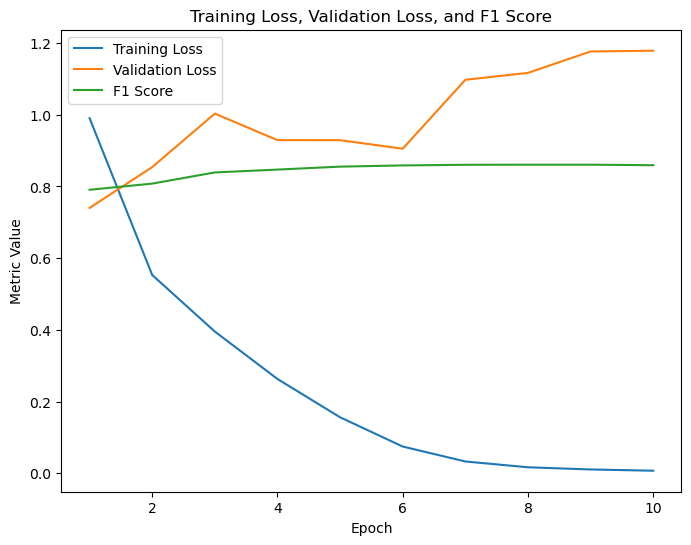

In [39]:
# Create a single subplot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot training loss
ax.plot(range(1, epochs + 1), training_loss_list, label='Training Loss')

# Plot validation loss
ax.plot(range(1, epochs + 1), validation_loss_list, label='Validation Loss')

# Plot F1-score
ax.plot(range(1, epochs + 1), f1_score_list, label='F1 Score')

# Set labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric Value')
ax.set_title('Training Loss, Validation Loss, and F1 Score')

# Set legend
ax.legend()

# Show the combined plot
plt.show()

In [40]:
# Create the metrics table
metrics_table = [
    ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
]
previous_results = None
for epoch in range(1, epochs + 1):
    row = [
        epoch,
        training_loss_list[epoch - 1],
        validation_loss_list[epoch - 1],
        f1_score_list[epoch - 1],
        accuracy_list[epoch - 1],
        precision_list[epoch - 1]
    ]

    # Compare with previous epoch results
    if previous_results is not None:
        if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
            row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
        if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
            row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
        if validation_loss_list[epoch - 1] > previous_results['val_loss']:
            row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
        if validation_loss_list[epoch - 1] < previous_results['val_loss']:
            row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
        if f1_score_list[epoch - 1] > previous_results['val_f1']:
            row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
        if f1_score_list[epoch - 1] < previous_results['val_f1']:
            row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red

    metrics_table.append(row)
    previous_results = {
        'loss_train_avg': training_loss_list[epoch - 1],
        'val_loss': validation_loss_list[epoch - 1],
        'val_f1': f1_score_list[epoch - 1]
    }

# Calculate total training time in minutes
total_time_minutes = total_training_time / 60

# Calculate total precision
total_precision = precision_list[-1]

# Add total training time and total precision rows to the table
metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
metrics_table.append(['Final Precision', '', '', '', '', total_precision])
metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])

# Print the table
print(tabulate(metrics_table, headers='firstrow'))


Epoch                 Training Loss         Validation Loss     F1 Score            Accuracy              Precision
--------------------  --------------------  ------------------  ------------------  ------------------  -----------
1                     0.9903249319029057    0.740173748803467   0.7907248376268841  0.8251121076233184     0.849949
2                     0.5530843209114003    0.8539395827092408  0.8079317446210739  0.820627802690583      0.860709
3                     0.39525855790404907   1.0032353615713245  0.8390777530041502  0.8654708520179372     0.868441
4                     0.2630351473203135    0.929145656477343   0.8470039674891462  0.8609865470852018     0.860621
5                     0.15620169965942385   0.9290453352089657  0.8552659437605683  0.8654708520179372     0.874253
6                     0.07457581777445496   0.9052205499280835  0.8586208168122407  0.8654708520179372     0.869362
7                     0.032941711816703544  1.0975182230981466  0.860388